In [1]:
import os
import sys
sys.path.append('../../scripts')
import cartopy.crs as ccrs
import cmweather
import dask
from dask.distributed import Client, LocalCluster
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colormaps as mcolormaps
import xarray as xr
from load_SAIdata import Cases
%matplotlib inline

In [2]:
#cluster = LocalCluster(silence_logs=40)
client = Client(silence_logs=40)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 28.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45699,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 28.00 GiB
Comm: tcp://127.0.0.1:34463,Total threads: 4
Dashboard: /proxy/36769/status,Memory: 7.00 GiB
Nanny: tcp://127.0.0.1:40049,


In [3]:
print(list(Cases.cases))

['lres.spinup', 'lres.sai20', 'lres.sai', 'mres.cnt', 'mres.sai', 'hres.ref.1', 'hres.ref.2', 'hres.ref.3', 'hres.ref.4', 'hres.ref.5', 'hres.ref.6', 'hres.cnt.1', 'hres.cnt.2', 'hres.cnt.3', 'hres.cnt.4', 'hres.cnt.5', 'hres.cnt.6', 'hres.sai.1', 'hres.sai.2', 'hres.sai.3', 'hres.sai.4', 'hres.sai.5', 'hres.sai.6']


In [4]:
%%time
tags = list(Cases.cases)[1:]
cam = {tag: Cases(tag).select('atm','h0').open_mfdataset(chunks={'time':4}) for tag in tags}
cam['mres.cnt.yavg'] = Cases('mres.cnt').select('atm','h0.avgYYYY').open_mfdataset(chunks={'time':4})
print(f"data size: {np.sum([cam[tag].nbytes for tag in cam])/1e12:.2f} TB")

Reading combined kerchunk reference file /home/jasperdj/kerchunk/lres_b.e10.B2000_CAM5.f09_g16.feedforward.001.cam2.h0.2000-01_2076-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/lres_b.e10.B2000_CAM5.f09_g16.feedforward_2050.001.cam2.h0.2000-01_2098-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/rcp8.5_co2_f05_t12.cam2.h0.2000-01_2074-09.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/mres_b.e10.B2000_CAM5.f05_t12.001.cam2.h0.2045-01_2098-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.001.cam2.h0.2002-12_2012-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.002.cam2.h0.2002-12_2007-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.003.cam2.h0.2002-12_2007-12.json
Reading combined kerchunk reference 

#### Preprocessing monthly data:

In [5]:
%%time

# set time to center of bounds
for tag,ds in cam.items():
    cam[tag]['time_bnds'] = cam[tag].time_bnds.compute()
    cam[tag]['time'] = cam[tag].time_bnds.mean('nbnd').assign_attrs(cam[tag].time.attrs)

# select years of hres ensembles
for tag in[t for t in cam if 'hres.ref' in t]:
    cam[tag] = cam[tag].sel(time=slice('2003','2007'))
for tag in[t for t in cam if ('hres.cnt' in t or 'hres.sai' in t)]:
    cam[tag] = cam[tag].sel(time=slice('2093','2097'))

# create ensemble mean
for exp in ['ref','cnt','sai']:
    dsets = [cam[tag].expand_dims('ens') for tag in [f'hres.{exp}.{i}' for i in range(1,6)]]
    cam[f'hres.{exp}.em'] = xr.concat(dsets, dim='ens').mean('ens', keep_attrs=True)
    # print(f'hres.{exp}.1')
    cam[f'hres.{exp}.em']['time_bnds'] = cam[f'hres.{exp}.1'].time_bnds

CPU times: user 7.38 s, sys: 783 ms, total: 8.16 s
Wall time: 11.8 s


#### Functions

In [6]:
def ListedColorMap(cmap, N, white=False):
    """Create a listed colormap for filled contours with N levels"""
    if isinstance(cmap, str):
        cmap = mcolormaps[cmap]
    new_colors = cmap(np.linspace(0,1,N+1))
    if white:
        new_colors[int(np.floor((N)/2))] = [1,1,1,1]
        new_colors[int(np.ceil((N)/2))] = [1,1,1,1]
    new_cmap = mcolors.ListedColormap(new_colors[1:-1])
    new_cmap.set_over(new_colors[-1])
    new_cmap.set_under(new_colors[0])
    return new_cmap

def annual_mean(da, tbnds):
    w = tbnds.diff('nbnd').dt.total_seconds().squeeze() # weights
    wgb = w.groupby('time.year')
    return (da*w).groupby('time.year').sum().where(wgb.count()==wgb.count().max())/wgb.sum()

### Compute and store GMST

mind the value of compute in to_netcdf!

In [7]:
%%time
os.makedirs('data/GMST', exist_ok=True)
for tag in cam:
    da = cam[tag]
    dagm = da[['TREFHT']].weighted(da.gw).mean(('lat','lon'),keep_attrs=True)
    dagm['time_bnds'] = da.time_bnds
    dagm.to_netcdf(f'data/GMST/{tag}.nc', mode='w', compute=True, encoding={'time':{'units':'days since 2000-01-01','calendar':'noleap'}})

CPU times: user 12.1 s, sys: 1.04 s, total: 13.1 s
Wall time: 48.7 s


In [7]:
%%time
GMST = {tag: xr.open_dataset(f'data/GMST/{tag}.nc') for tag in cam}

CPU times: user 142 ms, sys: 23.1 ms, total: 165 ms
Wall time: 235 ms


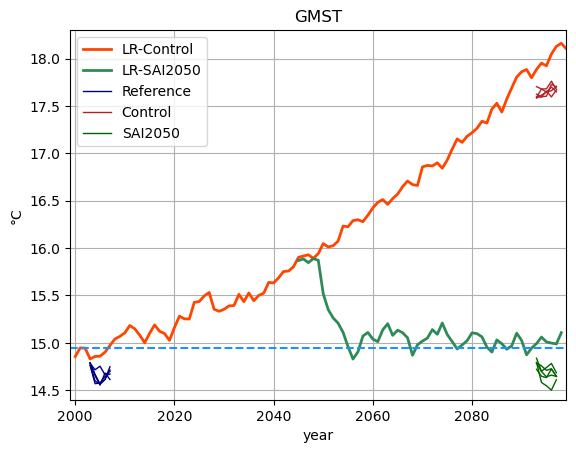

In [10]:
plots = {
    'mres.cnt.yavg':dict(label='LR-Control', c='orangered', lw=2, ls='-'),
    # 'mres.cnt': dict(label='mres Control', c='orangered', lw=2),
    'mres.sai': dict(label='LR-SAI2050', c='seagreen', lw=2),
    'hres.ref': dict(label='Reference', c='navy', lw=1),
    'hres.cnt': dict(label='Control', c='firebrick', lw=1),
    'hres.sai': dict(label='SAI2050', c='darkgreen', lw=1),
}
for tag,kwargs in plots.items():
    if 'mres' in tag:
        ann_gmst = annual_mean(GMST[tag].TREFHT, GMST[tag].time_bnds)
        (ann_gmst-273.15).plot(**kwargs)
    elif 'hres' in tag:
        for i in range(1,6):
            htag = f"{tag}.{i}"
            if i==2:
                kwargs['label'] = None
            ann_gmst = annual_mean(GMST[htag].TREFHT, GMST[htag].time_bnds)
            (ann_gmst-273.15).plot(**kwargs)
plt.gca().axhline(288.09713-273.15, xmin=0.0, xmax=1, ls='--', c='dodgerblue')
plt.legend()
plt.grid()
plt.xlim([1999,2099])
plt.ylim([14.4,18.3])
plt.ylabel('°C')
plt.title('GMST')

figname = 'GMST.pdf'
if not os.path.exists(f'fig/{figname}'):
    plt.savefig(f'fig/{figname}', transparent=True, bbox_inches='tight')
else:
    print('not saving...')

In [11]:
GMSTemam = {tag: annual_mean(cam[tag].TREFHT, cam[tag].time_bnds).mean('year', keep_attrs=True).compute()
            for tag in ['hres.ref.em','hres.cnt.em','hres.sai.em']}

CPU times: user 7.39 s, sys: 392 ms, total: 7.78 s
Wall time: 7.35 s


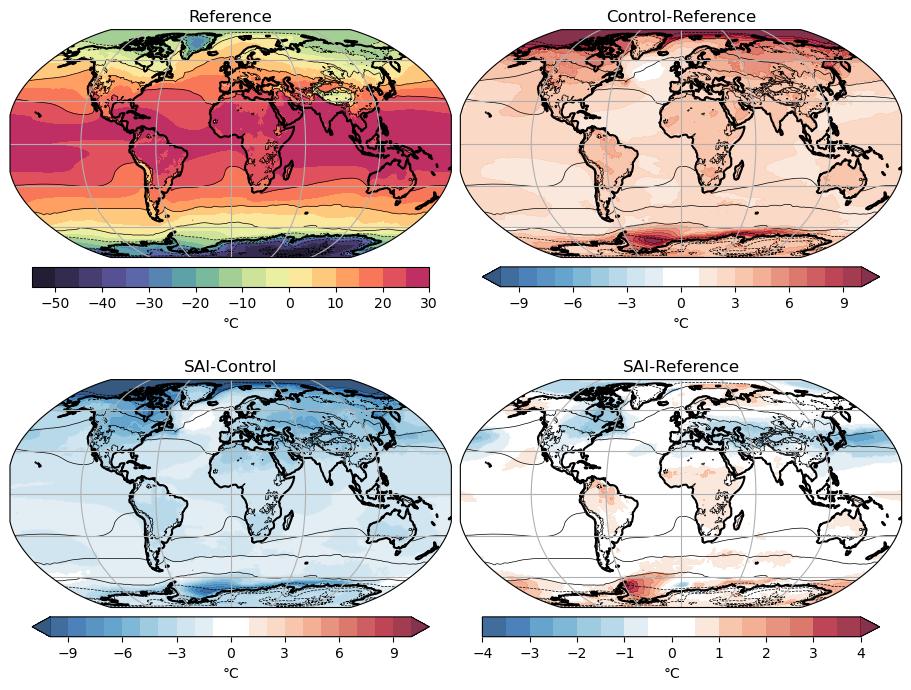

In [13]:
%%time

#loglevels, cmap, lognorm, cbticks = three_color_map(levs=[200,2000], Nlev=8, vmin=10, vmax=7000)
norm = mcolors.Normalize(vmin=-10, vmax=10)
levels = np.linspace(norm.vmin, norm.vmax, int(norm.vmax)*2+1)
cmap = ListedColorMap('RdBu_r', len(levels), white=True)

figdata = {
    0: {'title': 'Reference',
        'cfdata': GMSTemam['hres.ref.em']-273.15,
        'cfkwargs': dict(extend='neither', norm=mcolors.TwoSlopeNorm(vcenter=0, vmin=-60,vmax=50), levels=range(-55,31,5), 
                         cmap=cmweather.cm_colorblind.SpectralExtended),#'RdYlBu_r'), #cmap='YlGnBu'),
        'cbkwargs': dict(ticks=None)},
    1: {'title': 'Control-Reference',
        'cfdata': GMSTemam['hres.cnt.em'] - GMSTemam['hres.ref.em'],
        'cfkwargs': dict(norm=norm, levels=levels, alpha=0.8),
        'cbkwargs': dict(ticks=None)},
    2: {'title': 'SAI-Control',
        'cfdata': GMSTemam['hres.sai.em'] - GMSTemam['hres.cnt.em'],
        'cfkwargs': dict(norm=norm, levels=levels, alpha=0.8),
        'cbkwargs': dict(ticks=None)},
    3: {'title': 'SAI-Reference',
        'cfdata': GMSTemam['hres.sai.em'] - GMSTemam['hres.ref.em'],
        'cfkwargs': dict(extend='max', norm=mcolors.Normalize(vmin=-4, vmax=4), levels=np.linspace(-4,4,17), alpha=0.8),
        'cbkwargs': dict(ticks=None)},#range(-2,3))},
}
    
fig, axs = plt.subplots(2,2, figsize=(9,7), layout='constrained', subplot_kw={'projection':ccrs.Robinson()})
VARref = figdata[0]['cfdata']

for i,data in figdata.items():
    ax = axs.ravel()[i]
    ax.set_extent((-180,180,-90,90), crs=ccrs.PlateCarree())
    data = figdata[i]
    ds = data['cfdata']
    lons, lats = np.meshgrid(ds.lon, ds.lat)
    ax.coastlines(lw=1.5)
    gl = ax.gridlines()
    ax.set_title(data['title'])    
    cf = ax.contourf(lons, lats, ds, **(dict(extend='both', cmap=cmap, transform=ccrs.PlateCarree(), transform_first=True) | data['cfkwargs']))
    cs = ax.contour(lons, lats, VARref, levels=range(-50,31,10), colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), transform_first=True)
    cb = fig.colorbar(cf, ax=ax, **(dict(orientation='horizontal', shrink=0.9, pad=0.03, label='°C') | data['cbkwargs']))

figname = 'TREFHT_maps.pdf'
if not os.path.exists(f'fig/{figname}'):
    fig.savefig(f'fig/{figname}', transparent=True, bbox_inches='tight')
else:
    print('not saving...')

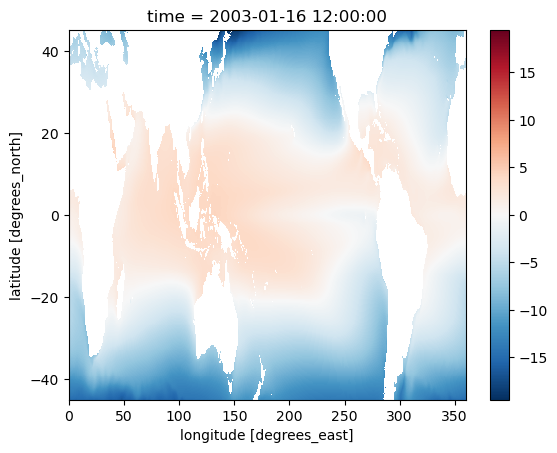

In [25]:
tag = 'hres.ref.em'
gw = cam[tag].gw.sel(lat=slice(-30,30))
mask = cam[tag].OCNFRAC.isel(time=0) > 0.9
GMST_tropmean = GMSTemam[tag].sel(lat=slice(-30,30)).weighted(gw).mean(('lat','lon')).compute()
(GMSTemam[tag] - GMST_tropmean).where(mask).sel(lat=slice(-45,45)).plot()

In [29]:
GMSTtrop

<xarray.DataArray (lat: 768, lon: 1152)> Size: 7MB
dask.array<where, shape=(768, 1152), dtype=float64, chunksize=(768, 1152), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 6kB -90.0 -89.77 -89.53 -89.3 ... 89.53 89.77 90.0
  * lon      (lon) float64 9kB 0.0 0.3125 0.625 0.9375 ... 359.1 359.4 359.7
    time     object 8B 2093-01-16 12:00:00

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 13.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 13.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3157: UserWarning: Sending large graph of size 13.51 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 6 s, sys: 235 ms, total: 6.23 s
Wall time: 7.5 s


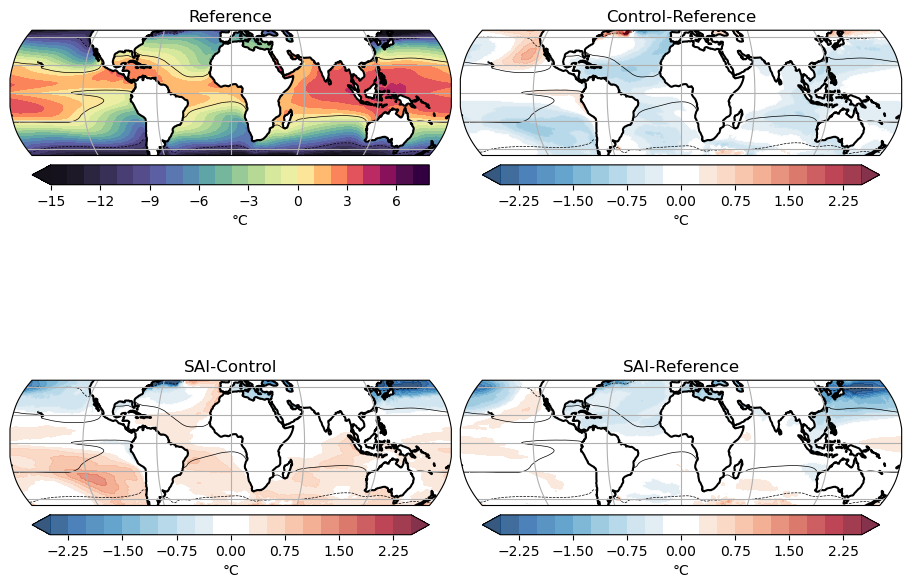

In [42]:
%%time

#loglevels, cmap, lognorm, cbticks = three_color_map(levs=[200,2000], Nlev=8, vmin=10, vmax=7000)
norm = mcolors.Normalize(vmin=-2.5, vmax=2.5)
levels = np.linspace(norm.vmin, norm.vmax, int(norm.vmax)*10+1)
cmap = ListedColorMap('RdBu_r', len(levels), white=True)

GMSTtrop = {}
for tag in GMSTemam:
    gw = cam[tag].gw.sel(lat=slice(-30,30))
    mask = cam[tag].OCNFRAC.isel(time=0) > 0.9
    GMST_tropmean = GMSTemam[tag].sel(lat=slice(-30,30)).weighted(gw).mean(('lat','lon')).compute()
    GMSTtrop[tag] = (GMSTemam[tag] - GMST_tropmean).where(mask)

figdata = {
    0: {'title': 'Reference',
        'cfdata': GMSTtrop['hres.ref.em'],
        'cfkwargs': dict(extend='min', norm=mcolors.TwoSlopeNorm(vcenter=0, vmin=-15,vmax=8), levels=np.arange(-15,8.01,1), 
                         cmap=cmweather.cm_colorblind.SpectralExtended),#'RdYlBu_r'), #cmap='YlGnBu'),
        'cbkwargs': dict(ticks=None)},
    1: {'title': 'Control-Reference',
        'cfdata': GMSTtrop['hres.cnt.em'] - GMSTtrop['hres.ref.em'],
        'cfkwargs': dict(norm=norm, levels=levels, alpha=0.8),
        'cbkwargs': dict(ticks=None)},
    2: {'title': 'SAI-Control',
        'cfdata': GMSTtrop['hres.sai.em'] - GMSTtrop['hres.cnt.em'],
        'cfkwargs': dict(norm=norm, levels=levels, alpha=0.8),
        'cbkwargs': dict(ticks=None)},
    3: {'title': 'SAI-Reference',
        'cfdata': GMSTtrop['hres.sai.em'] - GMSTtrop['hres.ref.em'],
        'cfkwargs': dict(extend='both', norm=mcolors.Normalize(vmin=-2.5, vmax=2.5), levels=np.linspace(-2.5,2.5,21), alpha=0.8,
                        cmap = ListedColorMap('RdBu_r', 21, white=True)),
        'cbkwargs': dict(ticks=None)},#range(-2,3))},
}
    
fig, axs = plt.subplots(2,2, figsize=(9,7), layout='constrained', subplot_kw={'projection':ccrs.Robinson()})
VARref = figdata[0]['cfdata']

for i,data in figdata.items():
    ax = axs.ravel()[i]
    ax.set_extent((-180,180,-45,45), crs=ccrs.PlateCarree())
    data = figdata[i]
    ds = data['cfdata']
    lons, lats = np.meshgrid(ds.lon, ds.lat)
    ax.coastlines(lw=1.5)
    gl = ax.gridlines()
    ax.set_title(data['title'])    
    cf = ax.contourf(lons, lats, ds, **(dict(extend='both', cmap=cmap, transform=ccrs.PlateCarree(), transform_first=True) | data['cfkwargs']))
    cs = ax.contour(lons, lats, VARref, levels=range(-50,31,10), colors='k', linewidths=0.5, transform=ccrs.PlateCarree(), transform_first=True)
    cb = fig.colorbar(cf, ax=ax, **(dict(orientation='horizontal', shrink=0.9, pad=0.03, label='°C') | data['cbkwargs']))

figname = 'TREFHT_relative_maps.pdf'
if not os.path.exists(f'fig/{figname}'):
    fig.savefig(f'fig/{figname}', transparent=True, bbox_inches='tight')
else:
    print('not saving...')

In [14]:
def three_color_map(levs=[200,2000], Nlev=4, vmin=10, vmax=7000):
    """Custom colormap from three individual maps, logarithmic norm and colorbar ticks

    Input:
        levs: levels (data  coordinates) that separate the colormaps
        Nlev: cmap resolution: number of color levels between levs, result will have 3*Nlev colors
        vmin: lower colorbar limit (will be adjusted to make evenly spaced levels)
        vmax: upper colorbar limit (will be adjusted to make evenly spaced levels)

    Returns:
        cmap: colormap, combination of 'Oranges','Greens' and 'Blues', trimmed
        lognorm: logarithmic norm instance
        cbticks: 
    """
    # create levels 
    loglevels = np.power(10,np.linspace(np.log10(levs[0]**2/levs[1]),np.log10(levs[1]**2/levs[0]),Nlev*3+1))
    loglevels[loglevels<vmin] = np.nan
    loglevels[loglevels>vmax] = np.nan
    clevels = (loglevels[1:]+loglevels[:-1])/2
    loglevels = loglevels[~np.isnan(loglevels)]
    
    # colormap
    id0, id1 = [np.argmin(np.abs(np.array(loglevels)-lev)) for lev in levs]
    colors = np.concatenate([
        plt.get_cmap('Oranges')(np.linspace(0.1,0.4,id1-id0)),
        plt.get_cmap('Greens')(np.linspace(0.1,0.9,id1-id0)),
        plt.get_cmap('Blues')(np.linspace(0.4,0.9,id1-id0)),
    ])
    colors = colors[~np.isnan(clevels)]
    cmap = mcolors.ListedColormap(colors)
    cmap.set_under(plt.get_cmap('Oranges')(0.0))
    cmap.set_over(plt.get_cmap('Blues')(0.8))

    # norm
    vmin = np.min(loglevels)
    vmax = np.max(loglevels)
    lognorm = mcolors.LogNorm(vmin=vmin, vmax=vmax)

    # colorbar ticks
    cbticks = np.array([i*(10**mult) for mult in range(-1,6) for i in range(1,10)])
    cbticks = cbticks[(cbticks>=vmin) * (cbticks<=vmax)]

    return loglevels, cmap, lognorm, cbticks

In [15]:
cam_EMTM = {tag: annual_mean(cam[tag].PRECT, cam[tag].time_bnds).mean('year', keep_attrs=True).compute()
            for tag in ['hres.ref.em','hres.cnt.em','hres.sai.em']}

CPU times: user 8.17 s, sys: 467 ms, total: 8.63 s
Wall time: 8.22 s


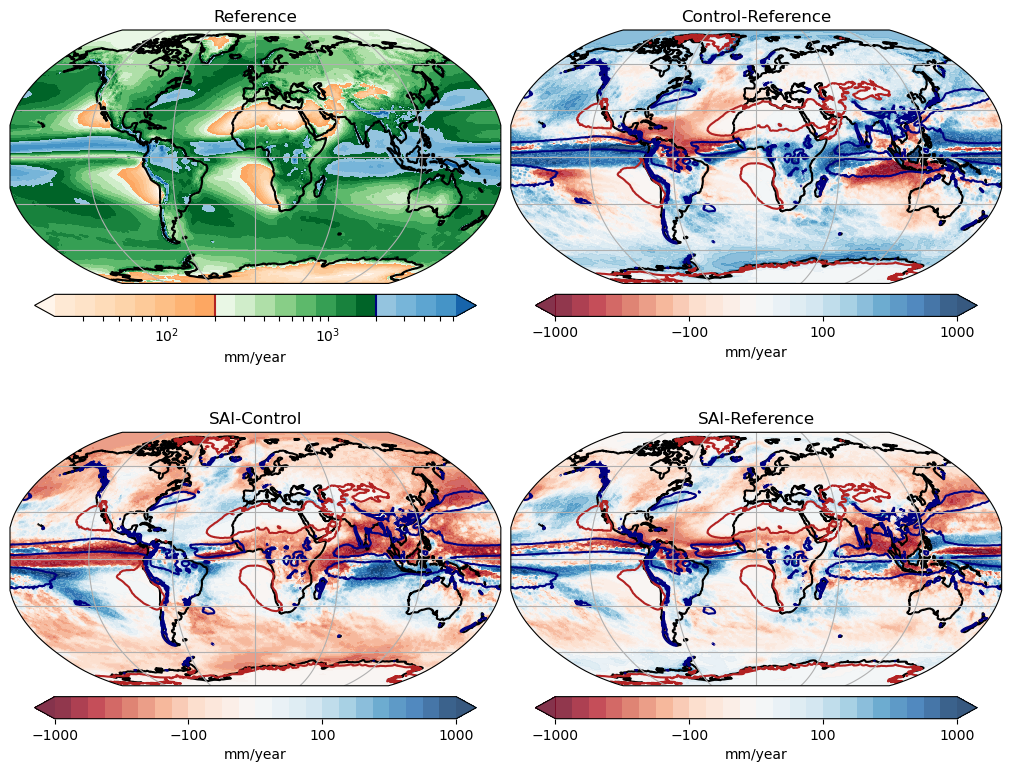

In [17]:
%%time
VAR = 'PRECT'
FAC = 1000*86400*365 # convert m/s to mm/year

loglevels, cmap, lognorm, cbticks = three_color_map(levs=[200,2000], Nlev=8, vmin=10, vmax=7000)
symlognorm = mcolors.SymLogNorm(100, linscale=0.3, vmin=-1000, vmax=1000)
symloglevels =[*np.arange(0,100,25), *np.power(10, np.linspace(np.log10(symlognorm.linthresh), np.log10(symlognorm.vmax), 9))]
symloglevels = [*-np.array(symloglevels)[-1:0:-1], *symloglevels]
symminorticks = [x*100 for x in range(-10,11)] #+ [x*10 for x in range(-10,9)] + [x*100 for x in range(1,11)]

figdata = {
    0: {'title': 'Reference',
        'cfdata': cam_EMTM['hres.ref.em'],
        'cfkwargs': dict(norm=lognorm, levels=loglevels, cmap=cmap), #cmap='YlGnBu'),
        'cbkwargs': dict(ticks=cbticks)},
    1: {'title': 'Control-Reference',
        'cfdata': cam_EMTM['hres.cnt.em'] - cam_EMTM['hres.ref.em'],
        'cfkwargs': dict(norm=symlognorm, levels=symloglevels, alpha=0.8),
        'cbkwargs': dict(ticks=[-1000,-100,100,1000])},
    2: {'title': 'SAI-Control',
        'cfdata': cam_EMTM['hres.sai.em'] - cam_EMTM['hres.cnt.em'],
        'cfkwargs': dict(norm=symlognorm, levels=symloglevels, alpha=0.8),
        'cbkwargs': dict(ticks=[-1000,-100,100,1000])},
    3: {'title': 'SAI-Reference',
        'cfdata': cam_EMTM['hres.sai.em'] - cam_EMTM['hres.ref.em'],
        'cfkwargs': dict(norm=symlognorm, levels=symloglevels, alpha=0.8),
        'cbkwargs': dict(ticks=[-1000,-100,100,1000])},
}
    
fig, axs = plt.subplots(2,2, figsize=(10,8), layout='constrained', subplot_kw={'projection':ccrs.Robinson()})
VARref = figdata[0]['cfdata'] * FAC

for i,data in figdata.items():
    ax = axs.ravel()[i]
    ax.set_extent((-180,180,-90,90), crs=ccrs.PlateCarree())
    data = figdata[i]
    ds = data['cfdata']
    # print(i,(ds[VAR]*FAC).quantile([0,0.01,0.99,1]).data)
    lons, lats = np.meshgrid(ds.lon, ds.lat)
    ax.coastlines(lw=1.5)
    gl = ax.gridlines()
    ax.set_title(data['title'])    
    VARavg = ds * FAC
    raster = i!=0
    cf = ax.contourf(lons, lats, VARavg, **(dict(extend='both', cmap='RdBu', transform=ccrs.PlateCarree(), transform_first=True) | data['cfkwargs']))
    cb = fig.colorbar(cf, ax=ax, **(dict(orientation='horizontal', shrink=0.9, pad=0.03, label='mm/year') | data['cbkwargs']))
    if i==0:
        # cb.ax.minorticks_on()
        cb.ax.axvline(200, c='firebrick', lw=1.5)
        cb.ax.axvline(2000, c='navy', lw=1.5)
    else:
        cs = ax.contour(lons, lats, VARref, levels=[200,2000], colors=['firebrick','navy'], linewidths=1.5, transform=ccrs.PlateCarree(), transform_first=True)
        # cb.ax.set_xticks(symminorticks, minor=True)

        
figname = 'PRECT_maps.png'
if not os.path.exists(f'fig/{figname}'):
    fig.savefig(f'fig/{figname}', dpi=500, transparent=True, bbox_inches='tight')
else:
    print('not saving...')

In [ ]:
cam_EMTM = {tag: annual_mean(cam[tag].PRECT, cam[tag].time_bnds).mean('year', keep_attrs=True).compute()
            for tag in ['hres.ref.em','hres.cnt.em','hres.sai.em']}